# Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Loading data and Analysis

In [2]:
customer_data = pd.read_csv("Mall_Customers.csv")

In [3]:
customer_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
customer_data.shape

(200, 5)

In [5]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
customer_data.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


# X matrix

In [7]:
X = customer_data.iloc[:,[3,4]].values
X[:11]

array([[15, 39],
       [15, 81],
       [16,  6],
       [16, 77],
       [17, 40],
       [17, 76],
       [18,  6],
       [18, 94],
       [19,  3],
       [19, 72],
       [19, 14]])

# K-Means Clustering Model

## Choosing the  optimum number of Clusters

### Finding WCSS value for different number of clusters

In [8]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)

    wcss.append(kmeans.inertia_)

### Plotting elbow graph

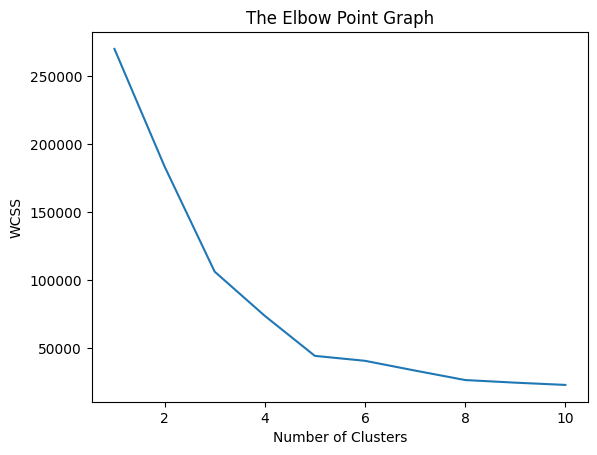

In [9]:
plt.plot(range(1,11), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

## Optimum Number of clusters from the elbow plot = 5

## Training the K-Means Clustering model with 5 clusters

In [10]:
kmeans = KMeans(n_clusters=5,init='k-means++',random_state=42)

In [11]:
y = kmeans.fit_predict(X)
print(y)

[4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4
 2 4 2 4 2 4 0 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 3 1 0 1 3 1 3 1 0 1 3 1 3 1 3 1 3 1 0 1 3 1 3 1
 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3
 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1]


# Visualizing all the clusters

## Plotting all clusters and their centroid

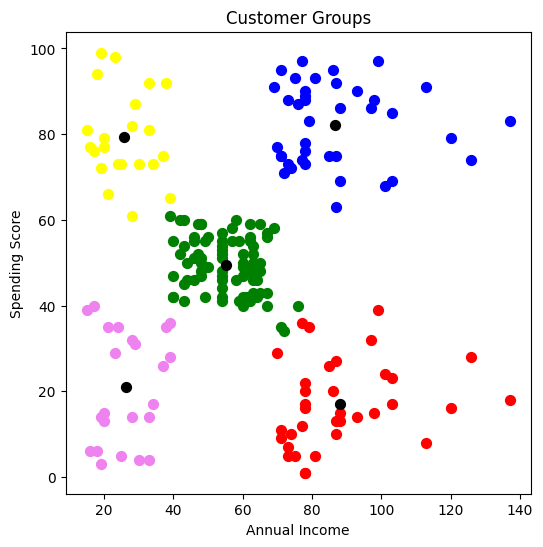

In [12]:
# Plotting all the clusters
plt.figure(figsize=(6,6))
plt.scatter(X[y==0,0], X[y==0,1], s=50, c='green', label='Cluster 1')
plt.scatter(X[y==1,0], X[y==1,1], s=50, c='blue', label='Cluster 2')
plt.scatter(X[y==2,0], X[y==2,1], s=50, c='yellow', label='Cluster 3')
plt.scatter(X[y==3,0], X[y==3,1], s=50, c='red', label='Cluster 4')
plt.scatter(X[y==4,0], X[y==4,1], s=50, c='violet', label='Cluster 5')

# plot the centroids
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=50, c='black', label='Centroids')

plt.title('Customer Groups')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.show()